In [20]:
import os
import importlib
import rippl_AI
import aux_fcn
import matplotlib.pyplot as plt
import numpy as np
importlib.reload(aux_fcn)
importlib.reload(rippl_AI)


<module 'rippl_AI' from 'c:\\SWR_repo\\rippl_AI.py'>

### Data download
3 uLED sessions will be downloaded: Amigo2 and Som2 will be used for training and Thy1 for validation


In [44]:
import os
from figshare.figshare.figshare import Figshare
fshare = Figshare()

article_ids = [16847521,16856137,14959449,14960085] 
sess=['Amigo2','Som2','Dlx1','Thy7']                                  
for id,s in zip(article_ids,sess):
    datapath = os.path.join('Downloaded_data', f'{s}')
    if os.path.isdir(datapath):
        print(f"{s} session already exists. Moving on.")
    else:
        print("Downloading data... Please wait, this might take up some time")        # Can take up to 10 minutes
        fshare.retrieve_files_from_article(id,directory=datapath)
        print("Data downloaded!")

Amigo2 session already exists. Moving on.
Som2 session already exists. Moving on.
Dlx1 session already exists. Moving on.
Data downloaded!


### Data load
The training sessions' LFP will be appended together in a list. The same will happen with the ripples detection times.
That is the required input for the training parser

In [2]:
# The training sessions will be appended together. Do the same with your training data
train_LFPs=[]
train_GTs=[]
# Amigo2
path=os.path.join('Downloaded_data','Amigo2','figshare_16847521')
LFP,GT=aux_fcn.load_lab_data(path)
train_LFPs.append(LFP)
train_GTs.append(GT)

# Som2
path=os.path.join('Downloaded_data','Som2','figshare_16856137')
LFP,GT=aux_fcn.load_lab_data(path)
train_LFPs.append(LFP)
train_GTs.append(GT)
## Append all your validation sessions
val_LFPs=[]
val_GTs=[]
# Dlx1 Validation
path=os.path.join('Downloaded_data','Dlx1','figshare_14959449')
LFP,GT=aux_fcn.load_lab_data(path)
val_LFPs.append(LFP)
val_GTs.append(GT)
# Thy07 Validation
path=os.path.join('Downloaded_data','Thy7','figshare_14960085')
LFP,GT=aux_fcn.load_lab_data(path)
val_LFPs.append(LFP)
val_GTs.append(GT)



Downloaded_data\Amigo2\figshare_16847521/hippo_2019-07-11_11-57-07_1150um_shank3.dat
fileStart  0
fileStop  1151451136
nSamples  575725568
nSamplesPerChannel  71965696
nSamplesPerChunk  10000
size data  71965696
Downloaded_data\Som2\figshare_16856137/hippo_2019-07-24_12-01-49_1530um_shank3.dat
fileStart  0
fileStop  497401856
nSamples  248700928
nSamplesPerChannel  31087616
nSamplesPerChunk  10000
size data  31087616
Downloaded_data\Dlx1\figshare_14959449/lfp_Dlx1-2021-02-12_12-46-54.dat
fileStart  0
fileStop  490242048
nSamples  245121024
nSamplesPerChannel  30640128
nSamplesPerChunk  10000
size data  30640128
Downloaded_data\Thy7\figshare_14960085/lfp_Thy7-2020-11-11_16-05-00.dat
fileStart  0
fileStop  357220352
nSamples  178610176
nSamplesPerChannel  22326272
nSamplesPerChunk  10000
size data  22326272


The training sessions are concatenated, the validation sessions are kept as different sessions

In [21]:
retrain_LFP_norm,retrain_GT,val_LFP_norm,val_GT=rippl_AI.prepare_retrain_data(train_LFPs,train_GTs,val_LFPs,val_GTs,sf=30000)

Original training data shape:  (71965696, 8)
Downsampling data at 1250 Hz...
Shape of downsampled data: (2998571, 8)
Normalizing data...
Original training data shape:  (31087616, 8)
Downsampling data at 1250 Hz...
Shape of downsampled data: (1295317, 8)
Normalizing data...
Original validation data shape:  (30640128, 8)
Downsampling data at 1250 Hz...
Shape of downsampled data: (1276672, 8)
Normalizing data...
Original validation data shape:  (22326272, 8)
Downsampling data at 1250 Hz...
Shape of downsampled data: (930261, 8)
Normalizing data...


# Retraining examples for the different models

### XGBOOST
XGBOOST does not require further parameters

Number of validation sessions: 2
Shape of train data: (2775000, 8), Number of train events: 1144
Shape of test data: (1500000, 8), Number of test events: 650
(173437, 16)
(93750, 16)
[16:03:45] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 6 pruned nodes, max_depth=7
[0]	validation_0-logloss:0.60718
[16:03:45] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=7
[1]	validation_0-logloss:0.53679
[16:03:46] INFO: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 2 pruned nodes, max_depth=7
[2]	validation_0-logloss:0.47803
[16:03:46] INFO: C:/buildkite-agent/builds/

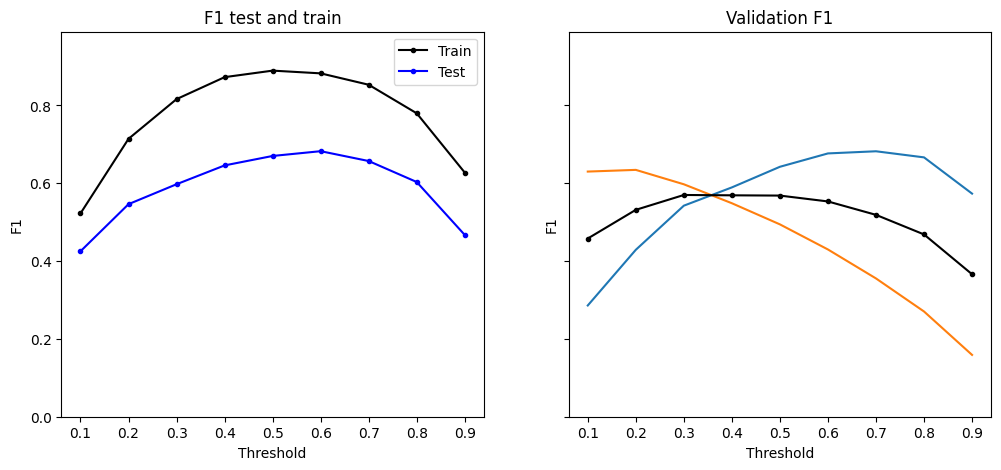

In [11]:
# No parameters needed
rippl_AI.retrain_model(retrain_LFP_norm,retrain_GT,val_LFP_norm,val_GT,arch='XGBOOST',
                       save_path=os.path.join('retrained_models','XGBOOST_retrained1'))

### SVM
Has only one parameter: 
'Undersampler proportion': It controls the number of windows with negatives (no ripples) that will be used to train the model. Following the formula: Undersampler proportion= (Positive windows)/(Negative windows). 1 means the same number of poitive and negative windows. Low values can lead to overfitting.

Number of validation sessions: 2
Shape of train data: (2925000, 8), Number of train events: 1202
Shape of test data: (1350000, 8), Number of test events: 592
(2925000, 1)
(1350000, 1)
Under sampling result: (768273, 8)


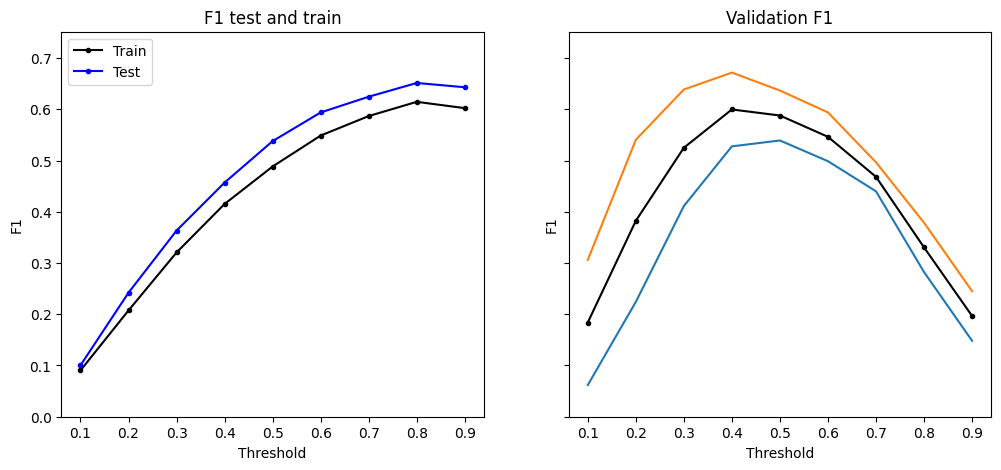

In [22]:
params={'Unsersampler proportion': 0.1}

rippl_AI.retrain_model(retrain_LFP_norm,retrain_GT,val_LFP_norm,val_GT,arch='SVM',parameters=params,
                       save_path=os.path.join('retrained_models','SVM_retrained1'))

### LSTM 
LSTM has two training parameters:
'Epochs': is the number of times that the training data is fed to the model
'Training batch': is the number of windows that are processed before updating the weights during training. Higher values prevent big weight oscillations.

Number of validation sessions: 2
Shape of train data: (3075000, 8), Number of train events: 1280
Shape of test data: (1200000, 8), Number of test events: 514
Input and output shape:  (96093, 32, 8) (96093, 32, 1)
1172/1172 [==============================] - 13s 11ms/step


INFO:tensorflow:Assets written to: retrained_models\LSTM_retrained1\assets


INFO:tensorflow:Assets written to: retrained_models\LSTM_retrained1\assets


909/909 [==============================] - 15s 17ms/step
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU


c:\Users\Adrian\miniconda3\envs\PublicBCG_d\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Adrian\miniconda3\envs\PublicBCG_d\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


x is empty. Cant perform IoU
x is empty. Cant perform IoU


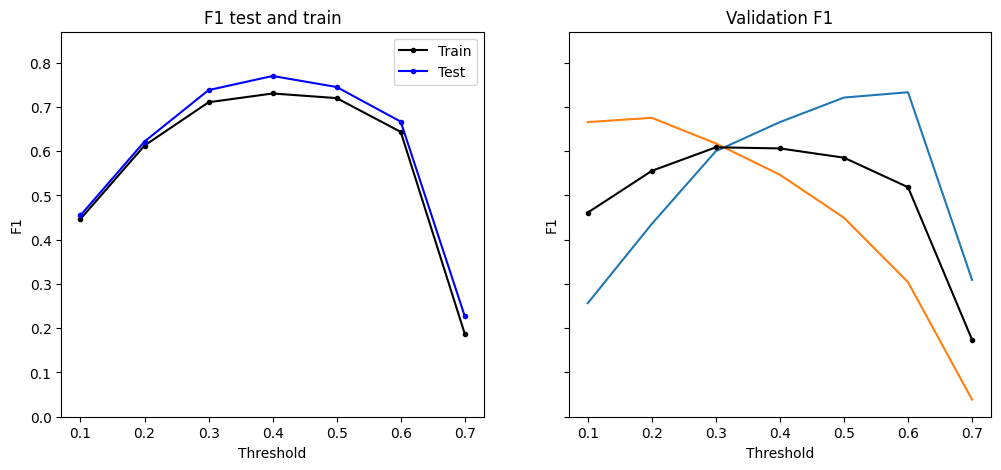

In [23]:
params={'Epochs': 2,
        'Training batch': 32}
rippl_AI.retrain_model(retrain_LFP_norm,retrain_GT,val_LFP_norm,val_GT,arch='LSTM',parameters=params,
                       save_path=os.path.join('retrained_models','LSTM_retrained1'))

### CNN2D
CNN2D share training parameters with th LSTM architecture

Number of validation sessions: 2
Shape of train data: (2625000, 8), Number of train events: 1050
Shape of test data: (1650000, 8), Number of test events: 744
1290/1290 [==============================] - 8s 7ms/step


INFO:tensorflow:Assets written to: retrained_models\CNN2D_retrained1\assets


INFO:tensorflow:Assets written to: retrained_models\CNN2D_retrained1\assets


727/727 [==============================] - 6s 8ms/step


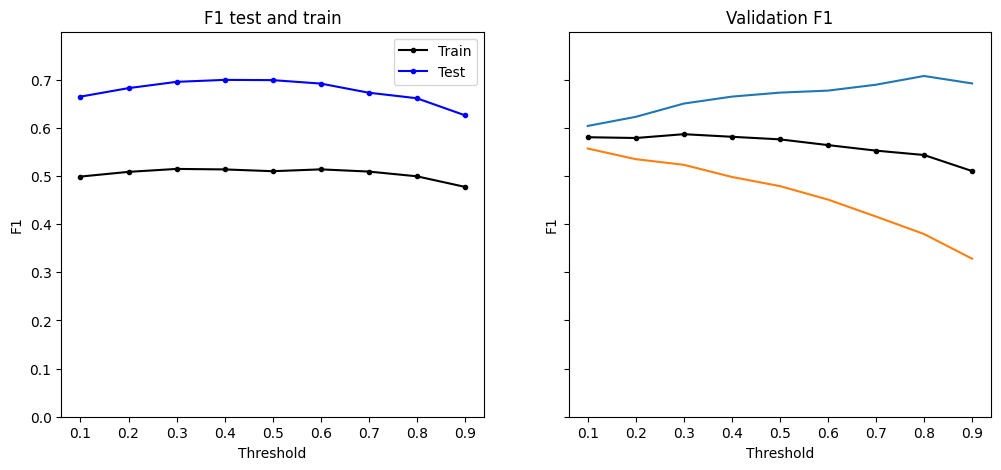

In [24]:
params={'Epochs': 1,
        'Training batch': 64}
rippl_AI.retrain_model(retrain_LFP_norm,retrain_GT,val_LFP_norm,val_GT,arch='CNN2D',parameters=params,
                       save_path=os.path.join('retrained_models','CNN2D_retrained1'))

### CNN1D
CNN1D share training parameters with LSTM and CNN2D

Number of validation sessions: 2
Shape of train data: (2925000, 8), Number of train events: 1219
Shape of test data: (1350000, 8), Number of test events: 575
Train Input and Output dimension (182812, 16, 8) (182812, 1)
Epoch 1/2
5713/5713 [==============================] - 22s 3ms/step - loss: 0.1154 - val_loss: 0.1182
Epoch 2/2
2637/2637 [==============================] - 3s 1ms/step


INFO:tensorflow:Assets written to: retrained_models\CNN1D_retrained1\assets


INFO:tensorflow:Assets written to: retrained_models\CNN1D_retrained1\assets


1817/1817 [==============================] - 2s 979us/step
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU
x is empty. Cant perform IoU


c:\Users\Adrian\miniconda3\envs\PublicBCG_d\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Adrian\miniconda3\envs\PublicBCG_d\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


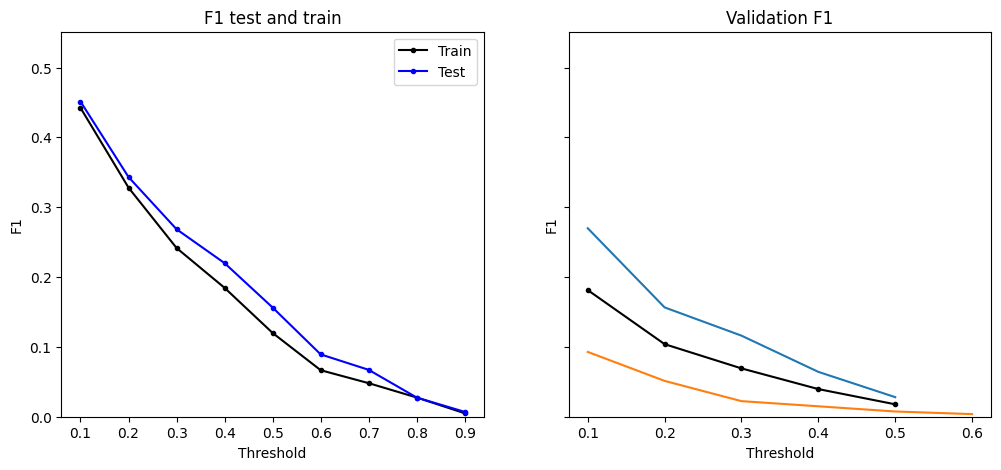

In [26]:
params={'Epochs': 2,
        'Training batch': 32}
rippl_AI.retrain_model(retrain_LFP_norm,retrain_GT,val_LFP_norm,val_GT,arch='CNN1D',parameters=params,save_path=os.path.join('retrained_models','CNN1D_retrained1'))